In [1]:
import os 
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import nlpaug
import nlpaug.augmenter.audio as naa

In [2]:
def gender_recognition(aud_file):

    #load the audio file
    y, sr = librosa.load(aud_file, sr=None)
     # adding loudness to audio files
    aug = naa.LoudnessAug(factor=(2, 5))
    X = aug.augment(y)
    r = librosa.autocorrelate(X, max_size=10000)
     #computations
    p2 = 500
    p1 = 50
    t1 = sr/p2
    t2 = sr/p1
    t3 = int(t2-t1+1)

    r[:int(t1)] = 0
    r[int(t2):] = 0
    
    t_pitch = r[:int(t2)].argmax()
    freq = float(sr)/t_pitch
    
    gender = ''
    #frequency range Male: 85-155; Female: 165-255
    if freq <= 160:
        gender = 'Male'
    else:
        gender = 'Female'

    return freq,gender

In [3]:
df = pd.read_csv('/Users/prem/Desktop/Speech_Corpus/gender_equal.csv')
df.head()

,Unnamed: 0,wave_id,transcript,Speaker,Gender,Age_Range,Pronunciation_dialect
0,10342,b0440,"There were stir and bustle, new faces, and fre...",1064,Male,Adult,American English
1,34924,b0205,You were destroying my life.,3593,Male,Adult,European English
2,56209,a0165,They are to attack your camp tomorrow night.,5739,Male,Adult,American English
3,57820,rp-10,Throughout the centuries people have explained...,5901,Male,Adult,Canadian English
4,38667,e0264,Please plan to attend a meeting on Friday. I w...,3973,Male,Adult,European English


In [4]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,wave_id,transcript,Speaker,Gender,Age_Range,Pronunciation_dialect
0,b0440,"There were stir and bustle, new faces, and fre...",1064,Male,Adult,American English
1,b0205,You were destroying my life.,3593,Male,Adult,European English
2,a0165,They are to attack your camp tomorrow night.,5739,Male,Adult,American English
3,rp-10,Throughout the centuries people have explained...,5901,Male,Adult,Canadian English
4,e0264,Please plan to attend a meeting on Friday. I w...,3973,Male,Adult,European English


In [5]:
rootdir ='/Users/prem/Desktop/Speech_Corpus'

In [6]:
Predict_Gender = []
for index_num,row in tqdm(df.iterrows()):
    aud_file = os.path.join(os.path.abspath(rootdir),str(row["Speaker"])+'/','wav/',str(row["wave_id"])+'.wav')
    aud_file_gender = row["Gender"]
    wave_id = row['wave_id']
    freq,predicted_gender = gender_recognition(aud_file)
    Predict_Gender.append([wave_id,aud_file_gender,freq,predicted_gender])

8354it [15:33,  8.95it/s]


In [7]:
# converting predicted_gender to Pandas dataframe
Predict_Gender_df = pd.DataFrame(Predict_Gender,columns=['Wave_Id','Actual_Gender','Frequency','Predicted_Gender'])
Predict_Gender_df.head()

,Wave_Id,Actual_Gender,Frequency,Predicted_Gender
0,b0440,Male,125.984252,Male
1,b0205,Male,115.107914,Male
2,a0165,Male,390.243902,Female
3,rp-10,Male,125.984252,Male
4,e0264,Male,129.032258,Male


8354it [00:01, 6433.96it/s]


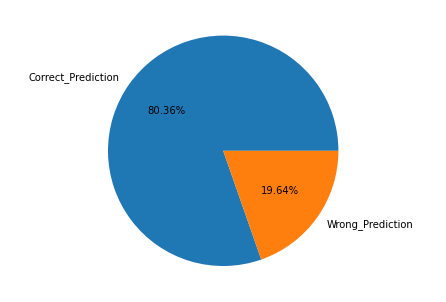

In [12]:
Correction_ratio = {'01':'Correct_Prediction','02':'Wrong_Prediction'}
total = {'01':0,'02':0}
dfs= []
cols = ['Wave_Id', 'Actual_Gender', 'Predicted_Gender','Frequency']
for index_num,row in tqdm(Predict_Gender_df.iterrows()):
    if str(row["Actual_Gender"]) == str(row["Predicted_Gender"]):
        num = '01'
    else:
        num = '02'
        dfs.append([row['Wave_Id'],row["Actual_Gender"],row["Predicted_Gender"],row['Frequency']])
    
    total[num] = total[num]+1
incorrect_df = pd.DataFrame(dfs, columns=cols)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
field = Correction_ratio.values()
value = total.values()
ax.pie(value, labels = field,autopct='%1.2f%%')
plt.show()

In [13]:
incorrect_df

,Wave_Id,Actual_Gender,Predicted_Gender,Frequency
0,a0165,Male,Female,390.243902
1,ar-16,Male,Female,500.000000
2,a0180,Male,Female,484.848485
3,b0336,Male,Female,470.588235
4,a0394,Male,Female,500.000000
...,...,...,...,...
1636,a0341,Female,Male,91.428571
1637,a0084,Female,Male,153.846154
1638,a0089,Female,Male,77.294686
1639,a0090,Female,Male,92.485549


In [10]:
incorrect_df.groupby(incorrect_df['Actual_Gender']).size()

Actual_Gender
Female     562
Male      1079
dtype: int64